In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns
import pingouin as pg

from matplotlib import rcParams
rcParams['figure.figsize'] = 15,6
plt.style.use("ggplot")

from src import data, paths,centroids
!date -I

2024-05-19


# Ensure that the greedy Dice mapping works

We want to ensure that the Dice mapping created in [DICE_02_glasser-schaefer200_maxdice.ipynb](./DICE_02_glasser-schaefer200_maxdice.ipynb) and our decision about ROI selection in F-Tract such that in corresponds to the ROI stimulated by TMS in TMS-EEG data makes sense. Because of that, we use it to map vector of Euclidean distances of ROIs from stimulated site in TMS-EEG (Schaefer200 parcellation) to a vector of Euclidean distances from selected stimulation site in F-Tract (Glasser parcellation). 

Load the mapping and coorinates of both parcellations:

In [2]:
mapping_glasser_schaefer = pd.read_csv(data.path('interim/DICE/Glasser_Schaefer200_labelMapping_greedy.csv'),index_col=0)
mapping_glasser_schaefer

,schaefer
regionName,
V1_L,7Networks_LH_Vis_10
V6_L,7Networks_LH_Vis_12
V2_L,7Networks_LH_Vis_13
V3_L,7Networks_LH_Vis_13
V4_L,7Networks_LH_Vis_2
...,...
FOP2_R,7Networks_RH_SomMot_3
PoI1_R,7Networks_RH_SalVentAttn_FrOperIns_2
Ig_R,7Networks_RH_SomMot_3


In [3]:
centroids_file = pd.read_csv(paths.path('external/glasser_parcellation_centriods/HCP-MMP1_UniqueRegionList.csv')) 

glasser_centroids = centroids_file[["regionName","x-cog","y-cog","z-cog"]].copy()
glasser_centroids

,regionName,x-cog,y-cog,z-cog
0,V1_L,100.491589,41.138901,71.637040
1,MST_L,132.416667,58.901786,82.059524
2,V6_L,104.543112,44.481665,103.916749
3,V2_L,102.236656,44.064791,74.401125
4,V3_L,107.926111,40.632159,76.961153
...,...,...,...,...
355,STSva_R,32.924419,117.527907,54.337791
356,TE1m_R,26.146605,102.236497,53.246528
357,PI_R,47.013363,123.157016,57.926503
358,a32pr_R,81.723096,153.990326,102.516324


In [4]:
glasser_centroids.replace({"7Pl_L":"7PL_L","7Pl_R":"7PL_R"},inplace=True) # known issue, Pl/PL differs accross Glasser versions

In [5]:
glasser_centroids['color'] = glasser_centroids["regionName"].apply(lambda x: 'r' if x == "4_L" else 'magenta' if x == "3b_L" else 'b')

Normalize the coordinates to [0,1] interval, because their space do not match accross the parcellations (one has only positive coordinates, the other has 0 in the center of the brain):

In [6]:
minimum = glasser_centroids[["x-cog","y-cog","z-cog"]].min(axis=None)
maximum = glasser_centroids[["x-cog","y-cog","z-cog"]].max(axis=None)

for c in ["x-cog","y-cog","z-cog"]:
    glasser_centroids[c+"_s"] = (glasser_centroids[c]-glasser_centroids[c].min()) / (maximum-minimum)
glasser_centroids

,regionName,x-cog,y-cog,z-cog,color,x-cog_s,y-cog_s,z-cog_s
0,V1_L,100.491589,41.138901,71.637040,b,0.445702,0.044836,0.273458
1,MST_L,132.416667,58.901786,82.059524,b,0.635495,0.150435,0.335419
2,V6_L,104.543112,44.481665,103.916749,b,0.469788,0.064708,0.465359
3,V2_L,102.236656,44.064791,74.401125,b,0.456077,0.062230,0.289890
4,V3_L,107.926111,40.632159,76.961153,b,0.489900,0.041823,0.305109
...,...,...,...,...,...,...,...,...
355,STSva_R,32.924419,117.527907,54.337791,b,0.044020,0.498963,0.170615
356,TE1m_R,26.146605,102.236497,53.246528,b,0.003726,0.408057,0.164127
357,PI_R,47.013363,123.157016,57.926503,b,0.127778,0.532428,0.191950
358,a32pr_R,81.723096,153.990326,102.516324,b,0.334125,0.715730,0.457033


Glasser ROIs, red is primary motor cortex, right is our selected ROI which we use as a counterpart to stimulated 7Networks_LH_SomMot_9 in Schaefer. It is not the best match, but there are more data in F-Tract for 3b_L than 1_L (the bst match). We see that the sites are close to each other:

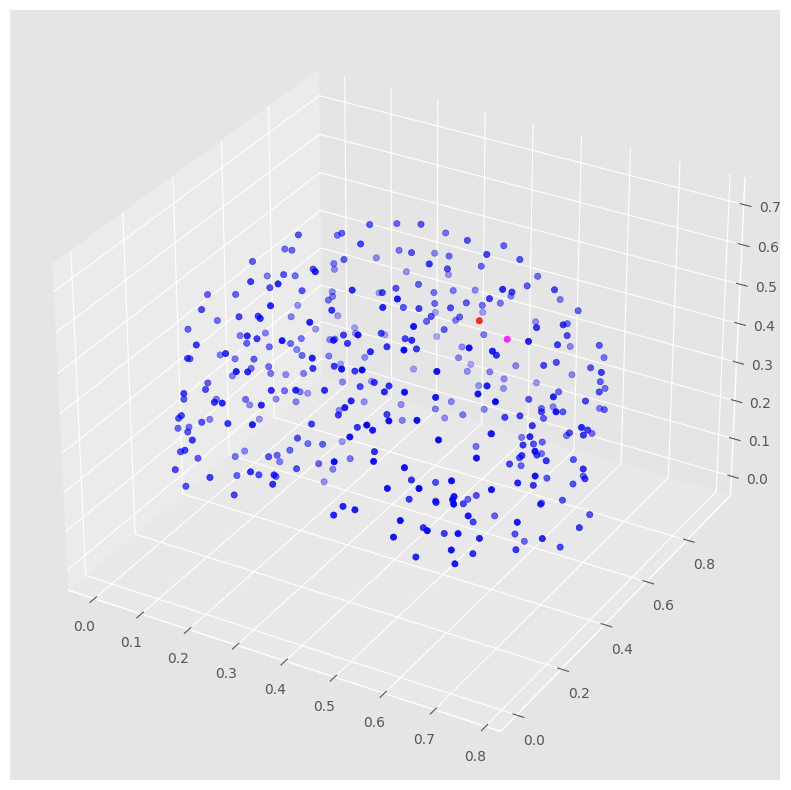

In [7]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(glasser_centroids["x-cog_s"], glasser_centroids["y-cog_s"], glasser_centroids["z-cog_s"],c=glasser_centroids["color"])
plt.show()

In [8]:
schaefer_centroids = pd.read_csv(data.path('external/schaefer_parcellation_centroids/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_2mm.Centroid_RAS.csv'),index_col=0)
schaefer_centroids

,ROI Name,R,A,S
ROI Label,,,,
1,7Networks_LH_Vis_1,-24,-54,-10
2,7Networks_LH_Vis_2,-26,-78,-14
3,7Networks_LH_Vis_3,-46,-70,-8
4,7Networks_LH_Vis_4,-10,-68,-4
5,7Networks_LH_Vis_5,-26,-96,-12
...,...,...,...,...
196,7Networks_RH_Default_PFCdPFCm_6,28,30,42
197,7Networks_RH_Default_PFCdPFCm_7,24,24,54
198,7Networks_RH_Default_pCunPCC_1,12,-54,14


Again, normalize the coordinates:

In [9]:
minimum = schaefer_centroids[["R","A","S"]].min(axis=None)
maximum = schaefer_centroids[["R","A","S"]].max(axis=None)

for c in ["R","A","S"]:
    schaefer_centroids[c+"_s"] = (schaefer_centroids[c]-schaefer_centroids[c].min()) / (maximum-minimum)
schaefer_centroids

,ROI Name,R,A,S,R_s,A_s,S_s
ROI Label,,,,,,,
1,7Networks_LH_Vis_1,-24,-54,-10,0.228916,0.253012,0.180723
2,7Networks_LH_Vis_2,-26,-78,-14,0.216867,0.108434,0.156627
3,7Networks_LH_Vis_3,-46,-70,-8,0.096386,0.156627,0.192771
4,7Networks_LH_Vis_4,-10,-68,-4,0.313253,0.168675,0.216867
5,7Networks_LH_Vis_5,-26,-96,-12,0.216867,0.000000,0.168675
...,...,...,...,...,...,...,...
196,7Networks_RH_Default_PFCdPFCm_6,28,30,42,0.542169,0.759036,0.493976
197,7Networks_RH_Default_PFCdPFCm_7,24,24,54,0.518072,0.722892,0.566265
198,7Networks_RH_Default_pCunPCC_1,12,-54,14,0.445783,0.253012,0.325301


In [10]:
schaefer_centroids["color"] = schaefer_centroids["ROI Name"].apply(lambda x: 'g' if x ==  "7Networks_LH_SomMot_9" else "y")

Schaefer centroids and stimulated site 7Networks_LH_SomMot_9:

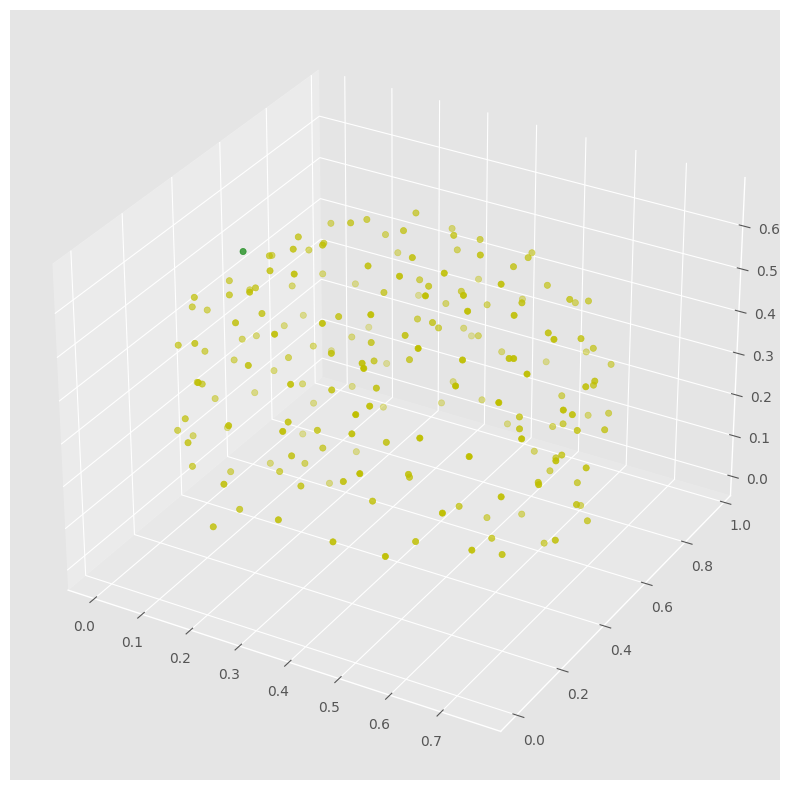

In [11]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(schaefer_centroids["R_s"], schaefer_centroids["A_s"], schaefer_centroids["S_s"],c=schaefer_centroids["color"])
plt.show()

We see that the x-coordinates are flipped for one of the parcellations:

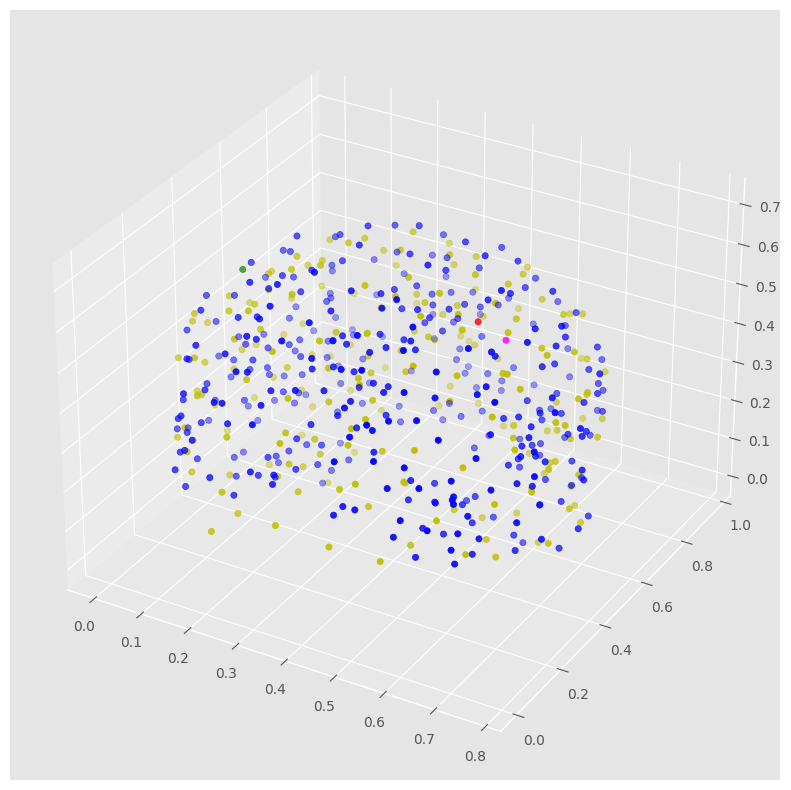

In [12]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(glasser_centroids["x-cog_s"], glasser_centroids["y-cog_s"], glasser_centroids["z-cog_s"],c=glasser_centroids["color"])
ax.scatter(schaefer_centroids["R_s"], schaefer_centroids["A_s"], schaefer_centroids["S_s"],c=schaefer_centroids["color"])
plt.show()

Flip the coordinate. And plot the other way round so we can see the stimulated site:

In [13]:
# flip x coordinate

glasser_centroids["x-cog_s_flip"] = -glasser_centroids["x-cog_s"]+glasser_centroids["x-cog_s"].max()

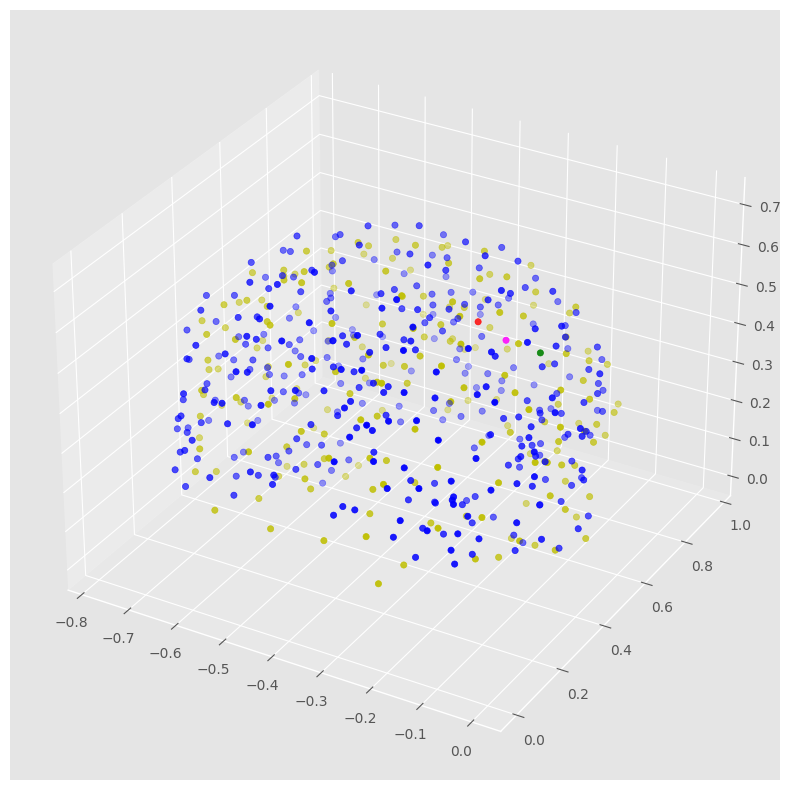

In [14]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(-glasser_centroids["x-cog_s_flip"], glasser_centroids["y-cog_s"], glasser_centroids["z-cog_s"],c=glasser_centroids["color"])
ax.scatter(-schaefer_centroids["R_s"], schaefer_centroids["A_s"], schaefer_centroids["S_s"],c=schaefer_centroids["color"])
plt.show()
# mínusy ve zobrazení jenom proto, aby bylo lépe vidět stimulované místo

Great, it seems ok, the stimulation site in Schaefer obtained from weights vector (see [02_pytepfit/02_stimulation-site-extraction.ipynb](../02_pytepfit/02_stimulation-site-extraction.ipynb)) is close to the one we selected as its counterpart in Glasser parcellation (see [DICE_02_glasser-schaefer200_maxdice.ipynb](./DICE_02_glasser-schaefer200_maxdice.ipynb)). Lets finish this and visualize wich regions are paired according to the Dice mapping table created in [DICE_02_glasser-schaefer200_maxdice.ipynb](./DICE_02_glasser-schaefer200_maxdice.ipynb).

In [15]:
mapping_coordinates = pd.merge(mapping_glasser_schaefer,glasser_centroids,on="regionName")
mapping_coordinates = pd.merge(mapping_coordinates,schaefer_centroids,left_on="schaefer",right_on="ROI Name")
mapping_coordinates

,regionName,schaefer,x-cog,y-cog,z-cog,color_x,x-cog_s,y-cog_s,z-cog_s,x-cog_s_flip,ROI Name,R,A,S,R_s,A_s,S_s,color_y
0,V1_L,7Networks_LH_Vis_10,100.491589,41.138901,71.637040,b,0.445702,0.044836,0.273458,0.327348,7Networks_LH_Vis_10,-12,-70,8,0.301205,0.156627,0.289157,y
1,V6_L,7Networks_LH_Vis_12,104.543112,44.481665,103.916749,b,0.469788,0.064708,0.465359,0.303262,7Networks_LH_Vis_12,-12,-72,22,0.301205,0.144578,0.373494,y
2,DVT_L,7Networks_LH_Vis_12,108.042324,53.086307,103.566805,b,0.490591,0.115862,0.463278,0.282459,7Networks_LH_Vis_12,-12,-72,22,0.301205,0.144578,0.373494,y
3,V2_L,7Networks_LH_Vis_13,102.236656,44.064791,74.401125,b,0.456077,0.062230,0.289890,0.316974,7Networks_LH_Vis_13,-6,-88,28,0.337349,0.048193,0.409639,y
4,V3_L,7Networks_LH_Vis_13,107.926111,40.632159,76.961153,b,0.489900,0.041823,0.305109,0.283150,7Networks_LH_Vis_13,-6,-88,28,0.337349,0.048193,0.409639,y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,Pir_R,7Networks_RH_SalVentAttn_FrOperIns_1,57.555081,133.362084,52.703672,b,0.190448,0.593097,0.160900,0.582603,7Networks_RH_SalVentAttn_FrOperIns_1,40,6,-16,0.614458,0.614458,0.144578,y
356,PI_R,7Networks_RH_SalVentAttn_FrOperIns_1,47.013363,123.157016,57.926503,b,0.127778,0.532428,0.191950,0.645273,7Networks_RH_SalVentAttn_FrOperIns_1,40,6,-16,0.614458,0.614458,0.144578,y
357,AVI_R,7Networks_RH_Cont_PFCv_1,58.445161,150.959140,67.720430,b,0.195739,0.697710,0.250174,0.577311,7Networks_RH_Cont_PFCv_1,34,22,-8,0.578313,0.710843,0.192771,y
358,AAIC_R,7Networks_RH_Cont_PFCv_1,54.936552,141.408966,60.337241,b,0.174881,0.640935,0.206281,0.598170,7Networks_RH_Cont_PFCv_1,34,22,-8,0.578313,0.710843,0.192771,y


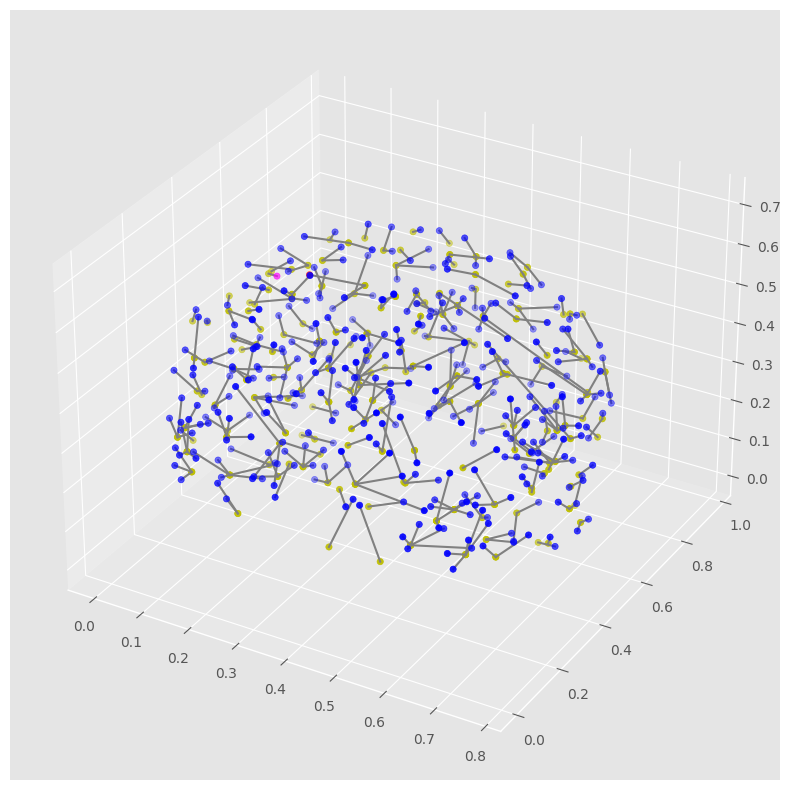

In [16]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(mapping_coordinates["x-cog_s_flip"], mapping_coordinates["y-cog_s"], mapping_coordinates["z-cog_s"],c=mapping_coordinates["color_x"])
ax.scatter(mapping_coordinates["R_s"], mapping_coordinates["A_s"], mapping_coordinates["S_s"],c=mapping_coordinates["color_y"])
for i,row in mapping_coordinates.iterrows():
    ax.plot([row["R_s"], row["x-cog_s_flip"]], [row["A_s"],row["y-cog_s"]],zs=[row["S_s"],row["z-cog_s"]],color="gray")
plt.show()

Ok, there are some discrepancies, but it seems usable overall.

Get matrices of Euclidean distances from the centroid coordinates above. First, show that the fact that we scaled and flipped the coordinates does not chaged anything:

,n,r,CI95%,p-val,BF10,power
pearson,129600,1.0,"[1.0, 1.0]",0.0,nan,1


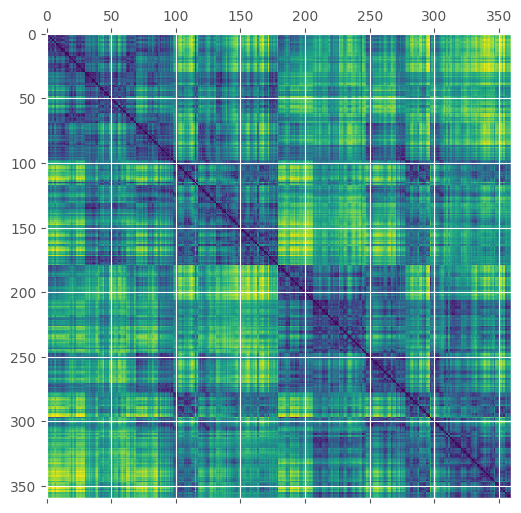

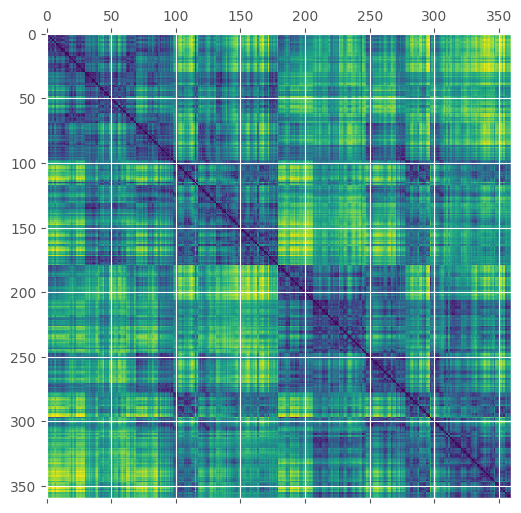

In [17]:
glasser_centroids_array = np.zeros((360,3))
glasser_centroids_array[:,0] = mapping_coordinates["x-cog"]
glasser_centroids_array[:,1] = mapping_coordinates["y-cog"]
glasser_centroids_array[:,2] = mapping_coordinates["z-cog"]

ED_glasser = centroids.roi_distances_from_centroids(glasser_centroids_array)

glasser_centroids_scaled_array = np.zeros((360,3))
glasser_centroids_scaled_array[:,0] = mapping_coordinates["x-cog_s_flip"]
glasser_centroids_scaled_array[:,1] = mapping_coordinates["y-cog_s"]
glasser_centroids_scaled_array[:,2] = mapping_coordinates["z-cog_s"]

ED_glasser_scaled_fliped = centroids.roi_distances_from_centroids(glasser_centroids_scaled_array)

plt.matshow(ED_glasser)
plt.matshow(ED_glasser_scaled_fliped)

pg.corr(ED_glasser.flatten(),ED_glasser_scaled_fliped.flatten())

The matrices are same.

Now, select the ROI we want to consider as stimulation site in Glasser parcellation and assign the vector of distances to our mapping table. Later, we assign the vector of distances in Schaefer so we can compare them:

In [18]:
GLASSER_STMULATED_ROI = "3b_L"

ED_glasser_labels = list(mapping_coordinates["regionName"])
id_m1 = ED_glasser_labels.index("3b_L")
ED_glasser_from_m1 = ED_glasser[id_m1]
mapping_coordinates["ED_glasser"] = ED_glasser_from_m1
mapping_coordinates

,regionName,schaefer,x-cog,y-cog,z-cog,color_x,x-cog_s,y-cog_s,z-cog_s,x-cog_s_flip,ROI Name,R,A,S,R_s,A_s,S_s,color_y,ED_glasser
0,V1_L,7Networks_LH_Vis_10,100.491589,41.138901,71.637040,b,0.445702,0.044836,0.273458,0.327348,7Networks_LH_Vis_10,-12,-70,8,0.301205,0.156627,0.289157,y,86.130607
1,V6_L,7Networks_LH_Vis_12,104.543112,44.481665,103.916749,b,0.469788,0.064708,0.465359,0.303262,7Networks_LH_Vis_12,-12,-72,22,0.301205,0.144578,0.373494,y,66.905377
2,DVT_L,7Networks_LH_Vis_12,108.042324,53.086307,103.566805,b,0.490591,0.115862,0.463278,0.282459,7Networks_LH_Vis_12,-12,-72,22,0.301205,0.144578,0.373494,y,58.217497
3,V2_L,7Networks_LH_Vis_13,102.236656,44.064791,74.401125,b,0.456077,0.062230,0.289890,0.316974,7Networks_LH_Vis_13,-6,-88,28,0.337349,0.048193,0.409639,y,81.759962
4,V3_L,7Networks_LH_Vis_13,107.926111,40.632159,76.961153,b,0.489900,0.041823,0.305109,0.283150,7Networks_LH_Vis_13,-6,-88,28,0.337349,0.048193,0.409639,y,81.100872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,Pir_R,7Networks_RH_SalVentAttn_FrOperIns_1,57.555081,133.362084,52.703672,b,0.190448,0.593097,0.160900,0.582603,7Networks_RH_SalVentAttn_FrOperIns_1,40,6,-16,0.614458,0.614458,0.144578,y,105.565302
356,PI_R,7Networks_RH_SalVentAttn_FrOperIns_1,47.013363,123.157016,57.926503,b,0.127778,0.532428,0.191950,0.645273,7Networks_RH_SalVentAttn_FrOperIns_1,40,6,-16,0.614458,0.614458,0.144578,y,107.475675
357,AVI_R,7Networks_RH_Cont_PFCv_1,58.445161,150.959140,67.720430,b,0.195739,0.697710,0.250174,0.577311,7Networks_RH_Cont_PFCv_1,34,22,-8,0.578313,0.710843,0.192771,y,102.368842
358,AAIC_R,7Networks_RH_Cont_PFCv_1,54.936552,141.408966,60.337241,b,0.174881,0.640935,0.206281,0.598170,7Networks_RH_Cont_PFCv_1,34,22,-8,0.578313,0.710843,0.192771,y,105.130417


Schaefer Euclidean distances:

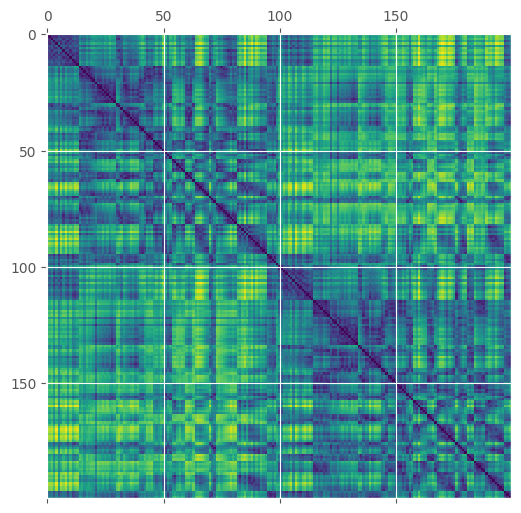

In [19]:
schaefer_centroids_array = np.zeros((200,3))
schaefer_centroids_array[:,0] = schaefer_centroids["R"]
schaefer_centroids_array[:,1] = schaefer_centroids["A"]
schaefer_centroids_array[:,2] = schaefer_centroids["S"]
schaefer_centroids_array

ED_schaefer = centroids.roi_distances_from_centroids(schaefer_centroids_array)
plt.matshow(ED_schaefer)

See once again that the primary motor cortex is not the right choice for mapping to 7Networks_LH_SomMot_9:

In [20]:
mapping_coordinates[mapping_coordinates["regionName"] == "4_L"]["schaefer"]

118    7Networks_LH_SomMot_15
Name: schaefer, dtype: object

3b_L is not perfect, but as we saw above, it is close enough (7Networks_LH_SomMot_10 is just next to 7Networks_LH_SomMot_9):

In [21]:
mapping_coordinates[mapping_coordinates["regionName"] == "3b_L"]["schaefer"]

120    7Networks_LH_SomMot_10
Name: schaefer, dtype: object

Extract the Euclidean distances from 7Networks_LH_SomMot_9:

In [22]:
ED_schaefer_labels = list(schaefer_centroids["ROI Name"])
id_m1 = ED_schaefer_labels.index("7Networks_LH_SomMot_9")
ED_schaefer_from_m1 = ED_schaefer[id_m1]
ED_schaefer_from_m1

array([ 74.88658091,  88.79189152,  76.57675888,  81.51073549,
        98.65089964,  69.10861017,  97.26253133,  62.28964601,
        88.31760866,  73.23933369,  72.91090453,  66.24198065,
        78.40918314,  72.11102551,  62.80127387,  46.56178691,
        42.19004622,  52.49761899,  38.67815921,  33.76388603,
        22.36067977,  44.22668877,   0.        ,   8.24621125,
        26.15339366,  18.86796226,  26.98147513,  35.38361203,
        45.29900661,  30.52867504,  78.68926229,  66.72330927,
        50.71488933,  15.3622915 ,  13.85640646,  27.49545417,
        54.44263036,  36.93237063,  52.80151513,  41.47288271,
        28.91366459,  43.22036557,  44.04543109,  38.78143886,
        31.36877428,  26.2297541 ,  65.11528238,  70.71067812,
        54.77225575,  58.54912467,  76.65507159,  58.34380858,
        38.20994635,  50.39841267,  94.08506789, 106.37668918,
       100.11992809,  86.46386528,  99.7196069 ,  82.51060538,
        24.8997992 ,  37.62977544,  17.32050808,  72.38

In [23]:
schaefer_centroids["ED_schaefer"] = ED_schaefer_from_m1
schaefer_centroids

,ROI Name,R,A,S,R_s,A_s,S_s,color,ED_schaefer
ROI Label,,,,,,,,,
1,7Networks_LH_Vis_1,-24,-54,-10,0.228916,0.253012,0.180723,y,74.886581
2,7Networks_LH_Vis_2,-26,-78,-14,0.216867,0.108434,0.156627,y,88.791892
3,7Networks_LH_Vis_3,-46,-70,-8,0.096386,0.156627,0.192771,y,76.576759
4,7Networks_LH_Vis_4,-10,-68,-4,0.313253,0.168675,0.216867,y,81.510735
5,7Networks_LH_Vis_5,-26,-96,-12,0.216867,0.000000,0.168675,y,98.650900
...,...,...,...,...,...,...,...,...,...
196,7Networks_RH_Default_PFCdPFCm_6,28,30,42,0.542169,0.759036,0.493976,y,96.622979
197,7Networks_RH_Default_PFCdPFCm_7,24,24,54,0.518072,0.722892,0.566265,y,88.836929
198,7Networks_RH_Default_pCunPCC_1,12,-54,14,0.445783,0.253012,0.325301,y,77.717437


...and merge it all together:

In [24]:
merge = pd.merge(mapping_coordinates,schaefer_centroids,on="ROI Name")
merge

,regionName,schaefer,x-cog,y-cog,z-cog,color_x,x-cog_s,y-cog_s,z-cog_s,x-cog_s_flip,...,color_y,ED_glasser,R_y,A_y,S_y,R_s_y,A_s_y,S_s_y,color,ED_schaefer
0,V1_L,7Networks_LH_Vis_10,100.491589,41.138901,71.637040,b,0.445702,0.044836,0.273458,0.327348,...,y,86.130607,-12,-70,8,0.301205,0.156627,0.289157,y,73.239334
1,V6_L,7Networks_LH_Vis_12,104.543112,44.481665,103.916749,b,0.469788,0.064708,0.465359,0.303262,...,y,66.905377,-12,-72,22,0.301205,0.144578,0.373494,y,66.241981
2,DVT_L,7Networks_LH_Vis_12,108.042324,53.086307,103.566805,b,0.490591,0.115862,0.463278,0.282459,...,y,58.217497,-12,-72,22,0.301205,0.144578,0.373494,y,66.241981
3,V2_L,7Networks_LH_Vis_13,102.236656,44.064791,74.401125,b,0.456077,0.062230,0.289890,0.316974,...,y,81.759962,-6,-88,28,0.337349,0.048193,0.409639,y,78.409183
4,V3_L,7Networks_LH_Vis_13,107.926111,40.632159,76.961153,b,0.489900,0.041823,0.305109,0.283150,...,y,81.100872,-6,-88,28,0.337349,0.048193,0.409639,y,78.409183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,Pir_R,7Networks_RH_SalVentAttn_FrOperIns_1,57.555081,133.362084,52.703672,b,0.190448,0.593097,0.160900,0.582603,...,y,105.565302,40,6,-16,0.614458,0.614458,0.144578,y,118.676030
356,PI_R,7Networks_RH_SalVentAttn_FrOperIns_1,47.013363,123.157016,57.926503,b,0.127778,0.532428,0.191950,0.645273,...,y,107.475675,40,6,-16,0.614458,0.614458,0.144578,y,118.676030
357,AVI_R,7Networks_RH_Cont_PFCv_1,58.445161,150.959140,67.720430,b,0.195739,0.697710,0.250174,0.577311,...,y,102.368842,34,22,-8,0.578313,0.710843,0.192771,y,115.412304
358,AAIC_R,7Networks_RH_Cont_PFCv_1,54.936552,141.408966,60.337241,b,0.174881,0.640935,0.206281,0.598170,...,y,105.130417,34,22,-8,0.578313,0.710843,0.192771,y,115.412304


In [25]:
merge.columns

Index(['regionName', 'schaefer', 'x-cog', 'y-cog', 'z-cog', 'color_x',
       'x-cog_s', 'y-cog_s', 'z-cog_s', 'x-cog_s_flip', 'ROI Name', 'R_x',
       'A_x', 'S_x', 'R_s_x', 'A_s_x', 'S_s_x', 'color_y', 'ED_glasser', 'R_y',
       'A_y', 'S_y', 'R_s_y', 'A_s_y', 'S_s_y', 'color', 'ED_schaefer'],
      dtype='object')

In [26]:
plt.style.use('ggplot')

See that it works, the Euclidean distances from the stimulated site in Schaefer and Glasser parcellation are similar:

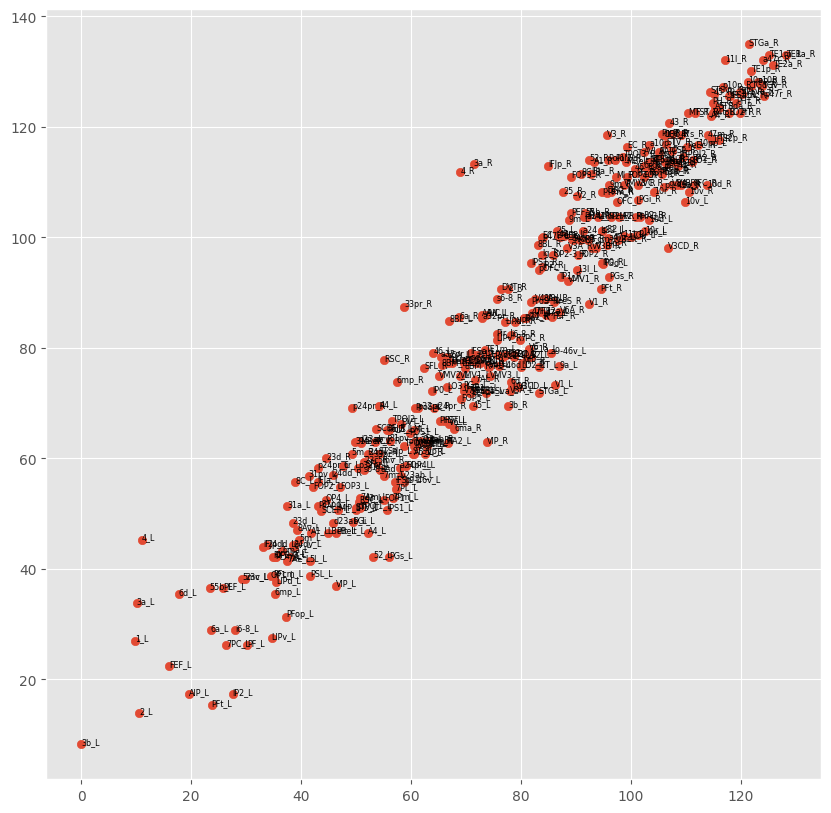

: 

In [27]:
def plot_two_columns(df,col1,col2,label):
    a1 = np.array(df[col1])
    a2 = np.array(df[col2])
        
    fig,ax = plt.subplots(figsize=(10,10))
    ax.scatter(a1,a2)

    for i, coor in enumerate(zip(a1,a2)):
        x,y = coor
        if np.isnan(x) or np.isnan(y):
            continue

        ax.text(x,y,df[label][i],fontsize='xx-small')

plot_two_columns(merge,"ED_glasser","ED_schaefer","regionName")